# GR5242 HW01 Problem 4: Early stopping and basic "deep dream"

### Fill in your code below `############# YOUR CODE HERE #############` and answers to reflection questions in the text box with **Your Answer Here**

In this exercise, you will explore some basic methods for preventing overfitting (early stopping and dropout) and explore model introspection by a basic version of Alex Mordvintsev's famous ["deep dream" experiment][deepdream].

## Early stopping and dropout

If we train a model which has lots of parameters (like a neural network) on a relatively simple task, and if your training dataset is relatively small, you are at risk of overfitting to the training dataset. Overfitting can lead to worse performance on data that wasn't used during training, such as test datasets or real new datapoints that your model will be applied to in production.

One way to avoid overfitting is called "early stopping": split your training dataset into two pieces, which we'll call the "training" and "validation" splits. Then, train your model on the training split until the loss on the validation split stops going down. At this point, we have some evidence that the model is starting to memorize the training set, since its performance on the validation set is not improving. This method is not foolproof, but it's easy to use and gives one answer to the question "When should I stop training?" which you would have to answer anyway.

Another way to avoid overfitting is called "dropout": during training, neurons are randomly turned off. This makes it harder for the model to memorize specific inputs. The neural network architecture (defined for you) below will make use of this.

## Deep dream

The goal of "deep dream" is to produce an image which produces strong activity in a unit in your neural network. This will help us understand what that unit is doing, since we can see what kinds of data it responds strongly to. We will perform a very simple version of the original deep dream experiment: find the input image which maximizes the activity of a neuron in a neural network trained to classify the MNIST digits. This will allow us to get some idea of what the network thinks a 0 is, or a 4 is, et cetera.


[deepdream]: https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html


## Setup cells

In [14]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
torch.__version__

'2.1.1'

In [15]:
# Load MNIST using torchvision
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])
MNIST_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
MNIST_test = datasets.MNIST('../data', train=False, transform=transform)

In [16]:
print('training samples:', len(MNIST_train))
print('testing samples:', len(MNIST_test))

# Access a specific data point (e.g., the 10th data point)
index = 10  # Change this to the index you want to access
sample_image, label = MNIST_train[index]

# Display the label and other information
print("MNIST raw data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.shape}")

training samples: 60000
testing samples: 10000
MNIST raw data
Data at index 10:
Label: 3
Image shape: torch.Size([1, 28, 28])


### Now let's show some example images

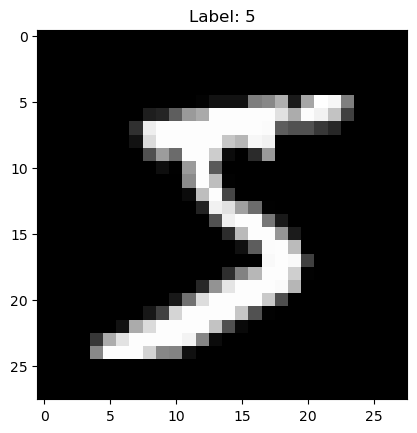

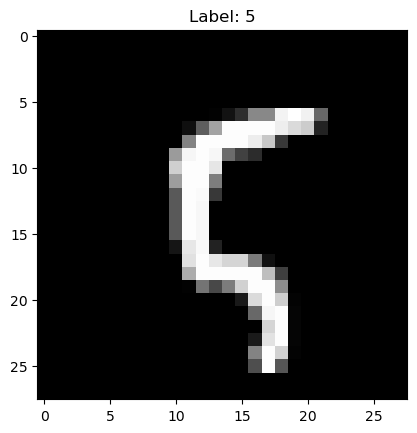

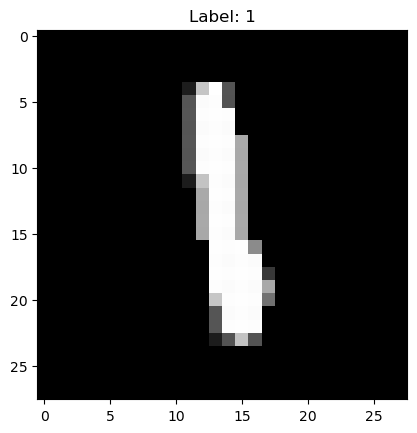

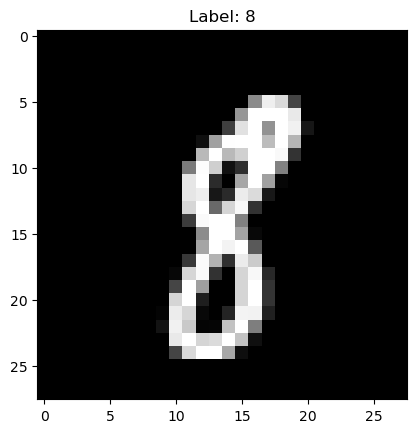

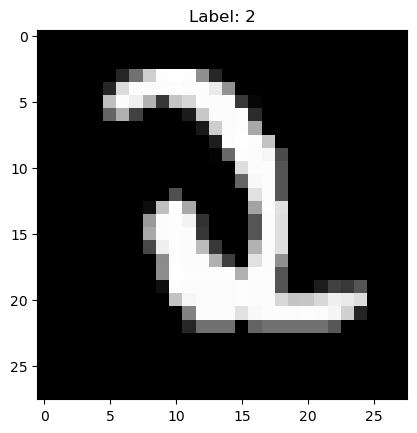

In [17]:
for i in range(5):  # Take example image 0,100,200,300,400
    index = i*100
    curr_f = MNIST_train[index][0]
    
    reshaped_curr_f = curr_f.permute(1, 2, 0)
    
    curr_lab = MNIST_train[index][1]
    plt.title("Label: %d" % curr_lab)
    plt.imshow(reshaped_curr_f, cmap='gray')
    plt.pause(0.5)

## Question 1: Training and validation split

Using `numpy` and `pytorch`, randomly split the training data in to a training and validation split. The training split should include 2/3 of the original data, and the validation split should include the remaining 1/3.

(Hint): you can try creating random lists of indices that go into training and validation, then use [`torch.utils.data.Subset()`](https://pytorch.org/docs/stable/data.html) (imported as [`Subset`](https://pytorch.org/docs/stable/data.html)) to split the `torchvision` dataset.

In [18]:
### QUESTION
# Please fill in the following cells by splitting the 'MNIST_train' dataset. You must assign name
# results using the variable names below.
# Create a train/validation split


############# YOUR CODE HERE ###############

# set random seed as 2023
np.random.seed(2023)
MNIST_train_old = MNIST_train

# get the number of data samples in training set
n = len(MNIST_train_old)
print(n)
# generate the randomly arranged index list
indices = np.random.permutation(n)

# split the index list into train_idx and val_idx
train_split = 40000
train_idx, val_idx = indices[:train_split], indices[train_split:]

# using the Subset package
MNIST_train = Subset(MNIST_train_old, train_idx)
MNIST_val = Subset(MNIST_train_old, val_idx)
print('After the data spliting:')
print('training samples:', len(MNIST_train))
print('validation samples:', len(MNIST_val))


60000
After the data spliting:
training samples: 40000
validation samples: 20000


Here, we define a 3-layer multilayer perceptron with dropout and prepare for fitting.

In [19]:
# Define a simple MLP network in PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Set up loss and optimization
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_dataloader = DataLoader(MNIST_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(MNIST_test, batch_size=32, shuffle=True)
val_dataloader = DataLoader(MNIST_val, batch_size=32, shuffle=True)

## Question 2: Early stopping

Write a for loop which alternates between training the model on 1 pass through the training split (also known as 1 epoch of training) and checking whether we should stop early by measuring the validation loss and seeing if it is still decreasing.

Please fill in the code to perform the validation step, including logic for early stopping. The code should have similar structure to how you might optimize on training data or evaluate on testing data.

Please also print your validation loss at each epoch.

In [20]:
### QUESTION
max_n_epochs = 10


prev_epoch_val_loss = np.inf
for epoch in range(max_n_epochs):
    # Set model to training mode
    model.train()
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Set model to evaluation mode for validation
    model.eval()
    
    ########## YOUR CODE HERE ###########
    # Initialize validation loss for this epoch
    current_val_loss = 0.0
    # Initialize the number of validation samples
    val_total_samples = len(MNIST_val)

    with torch.no_grad():
        for data, target in val_dataloader:
            output = model(data)
            loss = criterion(output, target)
            current_val_loss += (loss.item() * data.size(0))

    # Calculate the average loss
    average_loss = current_val_loss / val_total_samples

    # print the validation loss at this epoch
    print(f'Epoch {epoch+1}/{max_n_epochs}, Validation Loss: {average_loss}')

    # early stop
    if average_loss >= prev_epoch_val_loss:
        print('early stop')
        break

    # update prev_epoch_val_loss
    prev_epoch_val_loss = average_loss

Epoch 1/10, Validation Loss: 0.16900503079593182
Epoch 2/10, Validation Loss: 0.18582742135226726
early stop


As an extra check, we can look at the loss on the test dataset.

In [21]:
# Evaluate on the test set
model.eval()
test_loss = 0
with torch.no_grad():
    for data, target in train_dataloader:
        output = model(data)
        test_loss += criterion(output, target).item()

test_loss /= len(test_dataloader)
print(f"Test: loss={test_loss:.5f}")

Test: loss=0.55510


### Question 3: Test data written answer question

Would it have been good practice to use the test dataset instead of the validation split to perform early stopping above? Why or why not?

**Your Answer Here**

No, Using the test set as the validation set will also lead to the problem of overfitting, because if you do this, the early stopping mechanism will tend to select the model that performs better on the test set, and the resulting model will lose its generalization.

## Question 4: Basic "deep dream"

(4.a) Implement the basic "deep dream"

Our goal in this part of the problem is to find input images which maximally activate the output neuron corresponding to a particular class (for MNIST, that means corresponding to a particular digit). Let's pick the target class `0`.

We'll do this the same way we trained our neural net: start from random images, and use stochastic gradient descent on some cost function to improve the images.

Below, we have included code for randomly initializing the images, and for using the Adam optimizer to minimize a cost function. You are asked to fill in the cost function so that minimizing the cost function leads to maximizing the value of the "0" neuron in the output layer when the neural net is given `dream_images` as input. Make sure to use `dream_images` in your definition of `cost_function`.

(Hint): What value of the model output might you want to optimize if you want an image that is most likely labeled `0`? Remember to sum over the batch of data as well, and that you will be minimizing the cost. Remember as well that our optimizer is taking the `dream images` as parameters, not the model parameters.

In [22]:
### QUESTION
# "Deep dream"
# Construct random images

n_dream_images = 16
dream_images = torch.randn(n_dream_images, 1, 28, 28, requires_grad=True)
optimizer = optim.Adam([dream_images], lr=0.01)

########## YOUR CODE HERE ############

model.train()
def cost_function(images):
    output = model(images)
    return -output[:, 0].mean()



for i in range(1000):
    cost = cost_function(dream_images)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

dream_images = dream_images.detach()

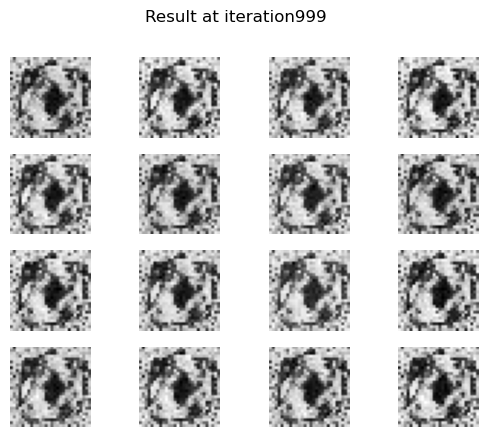

In [27]:
# Plotting the dream images
fig, axes = plt.subplots(
    ncols=4, nrows=n_dream_images // 4, sharex=True, sharey=True, dpi=100
)
for im, ax in zip(dream_images, axes.flat):
    ax.imshow(im[0].cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.suptitle(f"Result at iteration{i}")
plt.show()
plt.close(fig)

(4.b) After running the cell above to look at the result, do you have any reactions to what appears? In general, what can this basic version of deep dream tell us about our model?

**Your Answer Here**

(Open ended)

Through the analysis of deep dream, it can be seen that the model tends to identify the sample as shown in the figure above as the number 0, but from the perspective of the human eye, it can be seen that the sample is not the number 0, which shows that the model still has room for improvement. we may use convolutional neural networks to improve model's performance.